In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(
    context="paper",
    style="whitegrid",
    rc={
        "figure.figsize": (3.5, 3.5),
        "figure.dpi": 150,
        "savefig.dpi": 1000,
        "figure.constrained_layout.use": True,
        "pdf.fonttype": 42,
    },
)

In [2]:
df_cnn = pd.read_csv("../data/out/generalization/e7ivqipk.csv")
df_cnn["filter"] = "cnn"
df_lmb = pd.read_csv("../data/out/lmb_summary.csv")
df_glmb = pd.read_csv("../data/out/glmb_summary.csv")
df_combined = pd.concat([df_cnn, df_lmb, df_glmb]).reset_index(drop=True)

In [3]:
(
    df_combined.groupby(["scale", "filter"])["ospa"]
    .agg(["mean", "std"])
    .style.format("{:.0f}")
)

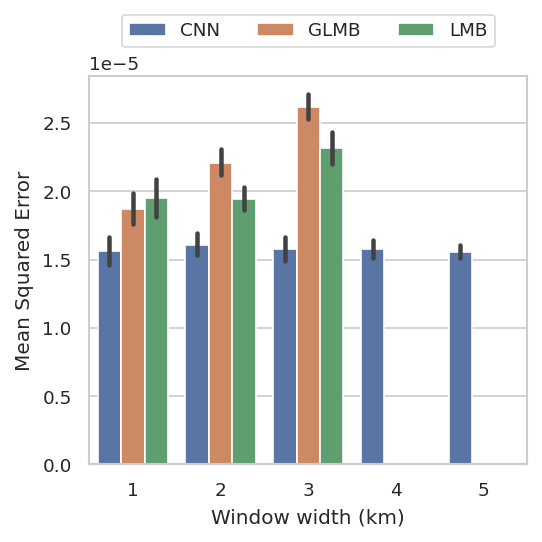

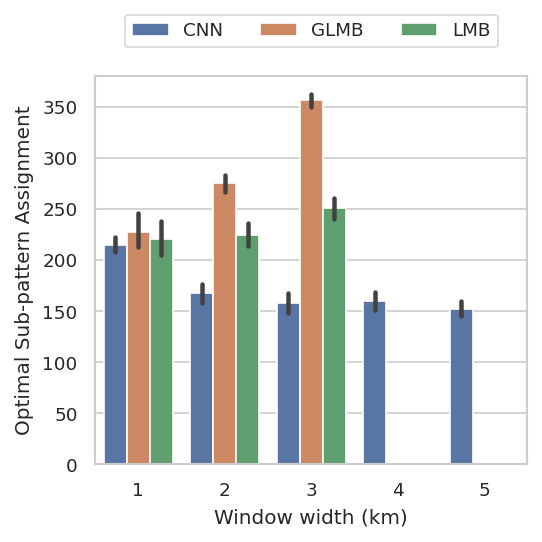

In [4]:
data = (
    df_combined.groupby(["filter", "scale", "simulation_idx"], as_index=False)
    .mean()
    .replace({"cnn": "CNN", "lmb": "LMB", "glmb": "GLMB"})
)

plt.figure()
sns.barplot(data=data, x="scale", y="mse", hue="filter", errorbar="ci")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.05), ncol=3, title=None)
plt.ylabel("Mean Squared Error")
plt.xlabel("Window width (km)")
plt.savefig("../figures/mtt_mse.pdf")
plt.savefig("../figures/mtt_mse.png")
plt.show()

plt.figure()
sns.barplot(data=data, x="scale", y="ospa", hue="filter", errorbar="ci")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.05), ncol=3, title=None)
plt.ylabel("Optimal Sub-pattern Assignment")
plt.xlabel("Window width (km)")
plt.savefig("../figures/mtt_ospa.pdf")
plt.savefig("../figures/mtt_ospa.png")
plt.show()

# plt.figure()
# sns.barplot(data=data.query("filter != 'CNN'"), x="scale", y="ospa1", hue="filter", errorbar="ci")
# plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.05), ncol=3, title=None)
# plt.ylabel("Optimal Sub-pattern Assignment (p=1)")
# plt.xlabel("Window width (km)")
# plt.savefig("../figures/ospa1.pdf")
# plt.savefig("../figures/ospa1.png")
# plt.show()

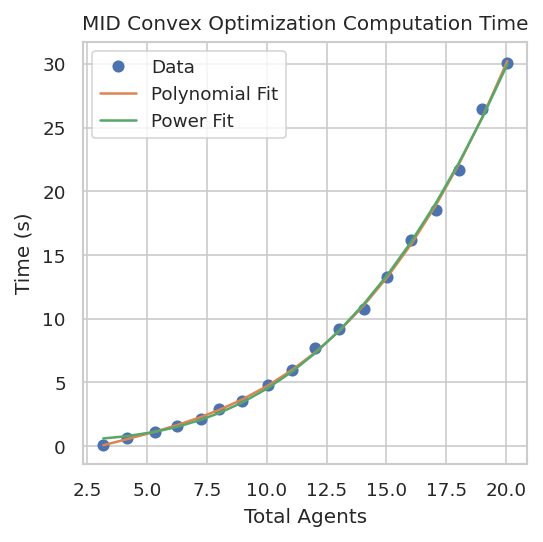

[0.00567768 2.85351466 0.45483753]


residual_poly     0.057955
residual_power    0.100046
dtype: float64

In [5]:
import numpy as np
from scipy.optimize import curve_fit

df_baseline = pd.read_csv("../data/baseline.csv")
agents = df_baseline["agents"].to_numpy()
time = df_baseline["time"].to_numpy()

# Fit a Polynomial Model
params_poly = np.polyfit(agents, time, deg=3)
time_poly = np.polyval(params_poly, agents)

# Fit an Exponential Model
def exp_model(x, a, b, c):
    return a * np.power(x, b) + c


params_power, _ = curve_fit(exp_model, agents, time, p0=[1, 1e-6, 1])
time_power = exp_model(agents, *params_power)

plt.figure()
plt.title("MID Convex Optimization Computation Time")
plt.xlabel("Total Agents")
plt.ylabel("Time (s)")
plt.plot(agents, time, "o", label="Data")
plt.plot(agents, time_poly, label="Polynomial Fit")
plt.plot(agents, time_power, label="Power Fit")
plt.legend()
plt.show()

df_baseline["time_poly"] = time_poly
df_baseline["time_power"] = time_power
# compute residuals
for model in ["poly", "power"]:
    df_baseline[f"residual_{model}"] = (
        df_baseline["time"] - df_baseline[f"time_{model}"]
    )
print(params_power)
df_baseline.filter(regex="residual_").pow(2).mean()

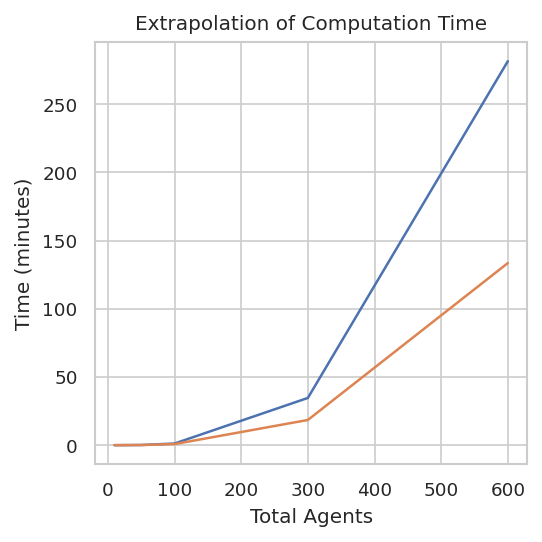

Extrapolated Runtime in Minutes


,agents,poly,power
0,10,0.078419,0.075116
1,50,8.429041,6.676499
2,100,72.475545,48.207787
3,300,2076.746972,1107.960730
4,600,16884.387778,8007.838630


In [6]:
# Extrapolate to 600 agents
agents_extrapolate = np.array([10, 50, 100, 300, 600])
time_poly_extrapolate = np.polyval(params_poly, agents_extrapolate)
time_exp_extrapolate = exp_model(agents_extrapolate, *params_power)

plt.figure()
plt.title("Extrapolation of Computation Time")
plt.xlabel("Total Agents")
plt.ylabel("Time (minutes)")
plt.plot(agents_extrapolate, time_poly_extrapolate / 60**2, label="Polynomial")
plt.plot(agents_extrapolate, time_exp_extrapolate / 60**2, label="Power")
plt.show()

print("Extrapolated Runtime in Minutes")
pd.DataFrame(
    dict(
        agents=agents_extrapolate,
        poly=time_poly_extrapolate / 60,
        power=time_exp_extrapolate / 60,
    )
)